In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
%cd /content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/shape.zip
!unzip -qq shape.zip

train_path = '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/shape/train'
test_path = '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/shape/test'

[Errno 20] Not a directory: '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/shape.zip'
/content


In [6]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(1),  # 1: 흑백  3: RGB
    transforms.ToTensor(),     # 0~1 사이로 정규화, 텐서로 변환
    transforms.RandomInvert(1),  # 색상 반전 (검은색 ↔ 흰색), 1: 100% 확률로 반전 (데이터 증강 기법)
    transforms.Normalize((0.5), (0.5))  # 각 픽셀 값을 (값 - 0.5) / 0.5로 정규화. 즉, 픽셀 값 범위가 [0, 1] → [-1, 1] 로 바뀌어 학습이 더 잘 되도록 도와준다.
])

# transfrom: 이미지를 28x28 흑백으로 변환한 뒤, 색상 반전과 정규화를 통해 학습에 적합한 텐서 형태로 전처리하는 함수

In [8]:
# 이미지 분류용 학습/테스트 데이터셋을 만들기 위한 코드
# ImageFolder를 사용해 폴더 구조에 따라 자동으로 라벨을 붙이고, 지정한 transform을 적용하여 PyTorch에서 사용 가능한 형태로 변환
trainset = torchvision.datasets.ImageFolder(root = train_path, transform = transform)
testset = torchvision.datasets.ImageFolder(root = test_path, transform = transform)

len(trainset), len(testset)

(240, 60)

In [9]:
# 예시
trainset.__getitem__(10)

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [10]:
trainset.classes, testset.classes

(['cir', 'tri', 'x'], ['cir', 'tri', 'x'])

In [11]:
class_map = {
    0: 'cir',
    1: 'tri',
    2: 'x'
}

In [13]:
loader = DataLoader(
    dataset = trainset,
    batch_size = 64,
    shuffle = True
)

imgs, labels = next(iter(loader))
# 학습 데이터 중 첫 번째 배치(이미지 64개와 라벨 64개)를 불러옴.
imgs.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

# **2. CNN모델 만들기**

In [19]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(28, 28, kernel_size = 3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(28, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(56, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        self.Linear = nn.Linear(56 * 7 * 7, 3)

    def forward(self, x):
        x = self.classifier(x)
        x= self.flatten(x)
        output = self.Linear(x)
        return output

In [20]:
# 장치 확인
device = 'cuda' if torch.cuda. is_available() else 'cpu'
device

'cpu'

In [21]:
model = ConvNeuralNetwork().to(device)
model

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
def train_loop(train_loader, model, loss_fn, optimizer):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(train_loader)
    avg_acc = sum_accs / len(train_loader)
    return avg_loss, avg_acc

In [24]:
epochs = 10

for i in range(epochs):
    print("------------------------------------------------------------------")
    avg_loss, avg_acc = train_loop(loader, model, loss, optimizer)
    print(f'Epoch {i:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')
print("Done!")

------------------------------------------------------------------
Epoch    0/10 Loss: 1.099005 Accuracy: 35.16%
------------------------------------------------------------------
Epoch    1/10 Loss: 1.059376 Accuracy: 38.28%
------------------------------------------------------------------
Epoch    2/10 Loss: 0.906144 Accuracy: 57.03%
------------------------------------------------------------------
Epoch    3/10 Loss: 0.612005 Accuracy: 70.31%
------------------------------------------------------------------
Epoch    4/10 Loss: 0.444031 Accuracy: 76.43%
------------------------------------------------------------------
Epoch    5/10 Loss: 0.430576 Accuracy: 77.08%
------------------------------------------------------------------
Epoch    6/10 Loss: 0.366082 Accuracy: 81.64%
------------------------------------------------------------------
Epoch    7/10 Loss: 0.315500 Accuracy: 85.42%
------------------------------------------------------------------
Epoch    8/10 Loss: 0.273987 

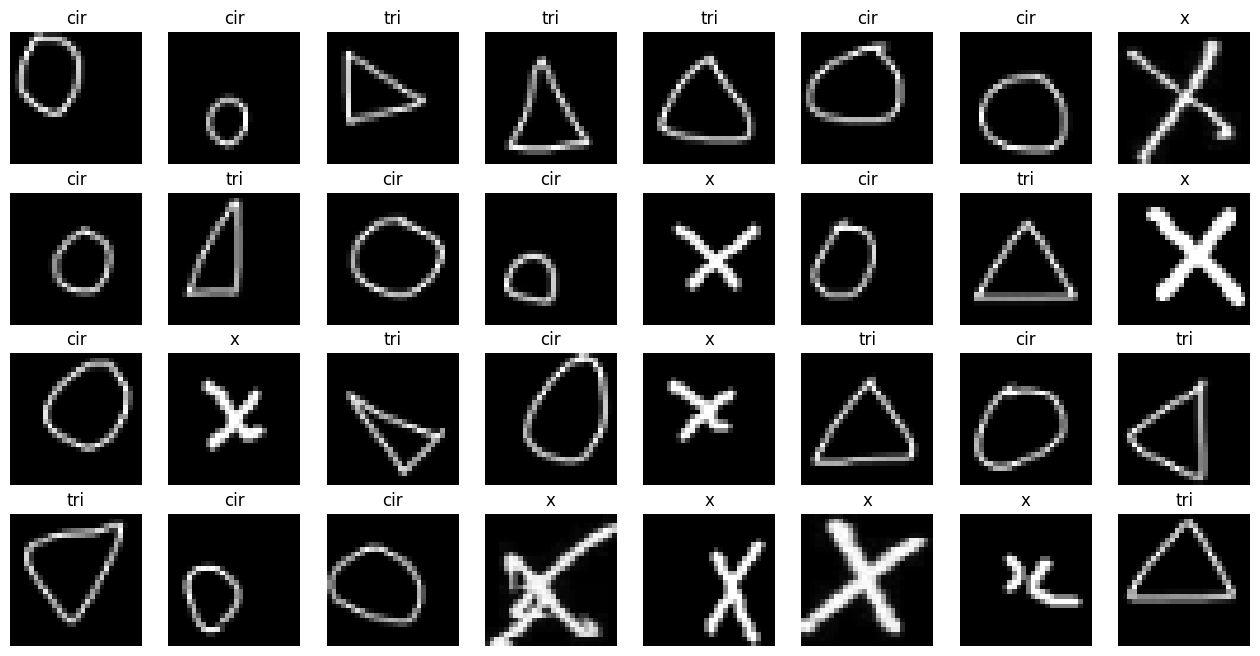

In [25]:
# 테스트 데이터 로드
test_loader = DataLoader(
    dataset=testset,
    batch_size=32,
    shuffle=True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')